### Блокнот для обучения классификатора

In [1]:
!pip3 install pandas numpy tqdm nltk pymystem3

/Users/kanelecake/.zshenv:.:1: no such file or directory: /Users/kanelecake/.cargo/env


You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.10/bin/python3.10 -m pip install --upgrade pip' command.


### Методы для препроцессинг

In [2]:
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from pymystem3 import Mystem
from nltk.stem.snowball import SnowballStemmer 

import numpy as np

from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
re1 = re.compile(r'[^\w\s]| {2,}')

russian_stopwords = set(stopwords.words('russian'))
stemmer = SnowballStemmer('russian')
mystem = Mystem()

def preprocess(src_text):
    clean_text = re.sub(re1, '', src_text)
    tokens = word_tokenize(clean_text)
    filtered_tokens = [token for token in tokens if token not in russian_stopwords]
    stemmed_tokens = [stemmer.stem(token) for token in filtered_tokens]
    lemmatized_text = mystem.lemmatize(' '.join(stemmed_tokens))
    return ''.join(lemmatized_text)

In [4]:
# Получает ключевые слова для заданного исходного текста через алгоритм tf-idf.
# Количество возвращаемых слов можно контролировать за счет параметра num_keywords.
def extract_keywords(src_text, num_keywords=5):
    tfidf_vectorizer = TfidfVectorizer()

    clean_text = re.sub(re1, '', src_text)
    tokens = word_tokenize(clean_text)
    filtered_tokens = [token for token in tokens if token not in russian_stopwords]

    prep_text = ' '.join(filtered_tokens)

    tfidf_matrix = tfidf_vectorizer.fit_transform([prep_text])
    feature_names = tfidf_vectorizer.get_feature_names_out()

    tfidf_scores = csr_matrix(tfidf_matrix).data

    sorted_indices = np.argsort(tfidf_scores)[::-1]
    top_indices = sorted_indices[:num_keywords]
    top_keywords = [feature_names[idx] for idx in top_indices]

    return top_keywords

### Чтение датасета

In [5]:
import pandas as pd
from tqdm.auto import tqdm

In [6]:
data = pd.read_csv('dataset/train_data.csv')
data.head(5)

,Question,Category,answer_class
0,Какие документы я получу после завершения обуч...,Документы,0
1,Где можно узнать о выдаче сертификатов по окон...,Документы,0
2,Каким образом выдают подтверждения о пройденно...,Документы,0
3,Какие виды сертификатов или удостоверений дост...,Документы,0
4,"Существуют ли аккредитации, которые я получу п...",Документы,0


In [7]:
classes = list(data['Category'].unique())
classes

['Документы',
 'Организация уроков',
 'Оценки',
 'Перевод/ запись в группу',
 'Практические работы',
 'Программа обучения',
 'Портал',
 'Расписание',
 'Требования ПО',
 'Трудоустройство']

In [8]:
df_res = pd.DataFrame()

for doc_class in tqdm(classes):
    df_class = data[data['Category'] == doc_class]
    df_res = pd.concat([df_res, df_class], ignore_index=True)

  0%|          | 0/10 [00:00<?, ?it/s]

In [9]:
prep_text = [preprocess(str(text).lower()) for text in tqdm(df_res['Question'])]
df_res['QuestionPrepared'] = prep_text
df_res['Keywords'] = [' '.join(extract_keywords(str(text).lower())) for text in tqdm(df_res['Question'])]

df_res = df_res.sample(frac=1).reset_index(drop=True)
df_res.head(1)

  0%|          | 0/7155 [00:00<?, ?it/s]

  0%|          | 0/7155 [00:00<?, ?it/s]

,Question,Category,answer_class,QuestionPrepared,Keywords
0,Каков график перерывов на платформе GB в 2024 ...,Расписание,21,как график перерыв платформа gb 2024 год\n,платформе перерывов каков график году


### Подготовка датасет к обучению

In [10]:
!pip3 install scikit-learn

/Users/kanelecake/.zshenv:.:1: no such file or directory: /Users/kanelecake/.cargo/env
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.10/bin/python3.10 -m pip install --upgrade pip' command.


In [11]:
from sklearn.model_selection import train_test_split

X = df_res['Keywords']
y = df_res['Category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state = 64)


In [12]:
categories = df_res['Category'].unique()
categories

array(['Расписание', 'Перевод/ запись в группу', 'Оценки', 'Документы',
       'Портал', 'Трудоустройство', 'Организация уроков', 'Требования ПО',
       'Практические работы', 'Программа обучения'], dtype=object)

### Модель

In [13]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

logreg = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegressionCV(max_iter=1000, tol=1e-3))
])

In [14]:
%%time
logreg.fit(X_train.values, y_train.values)

CPU times: user 17.7 s, sys: 547 ms, total: 18.3 s
Wall time: 2.91 s


Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegressionCV(max_iter=1000, tol=0.001))])

In [15]:
%%time
y_pred = logreg.predict(X_test.values)

CPU times: user 10.1 ms, sys: 1.42 ms, total: 11.5 ms
Wall time: 10.9 ms


In [16]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.939203354297694
                          precision    recall  f1-score   support

               Документы       0.96      0.96      0.96       451
      Организация уроков       0.88      0.89      0.89       444
                  Оценки       0.99      0.98      0.99       171
Перевод/ запись в группу       0.98      0.93      0.95       142
                  Портал       0.96      0.96      0.96       400
     Практические работы       0.98      0.96      0.97       177
      Программа обучения       0.88      0.90      0.89       310
              Расписание       0.94      0.94      0.94       232
           Требования ПО       0.99      1.00      0.99       233
         Трудоустройство       0.91      0.91      0.91       302

                accuracy                           0.94      2862
               macro avg       0.95      0.94      0.95      2862
            weighted avg       0.94      0.94      0.94      2862



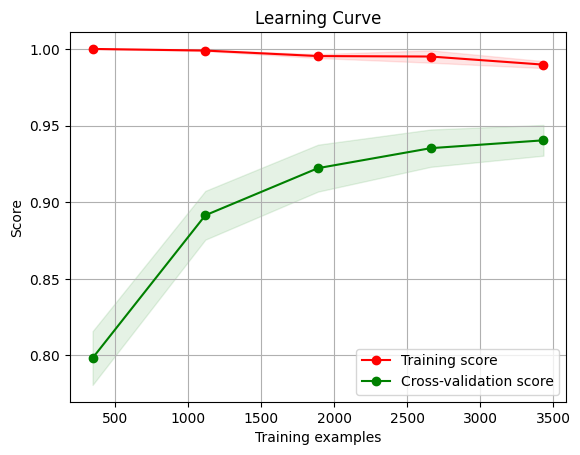

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Функция для построения кривой обучения
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Используем функцию для построения кривой обучения
plot_learning_curve(logreg, "Learning Curve", X_train.values, y_train.values, cv=5)
plt.show()


### Проверка

In [20]:
val_data = pd.read_csv("check_classifier.csv")
val_questions = val_data['Question'].tolist()
val_category = val_data['Category'].tolist()

count = 0
for i in range(0, len(val_questions)):
    prediction = logreg.predict([val_questions[i]]) 
    if prediction[0] == val_category[i]:
        count += 1
    else:
        print(val_questions[i])
        print(prediction[0], val_category[i])

print("Correct: ", count, ", accurancy: ", count / len(val_questions))

Какие требования предъявляются к студенту для успешного прохождения аттестаций?
Требования ПО Документы
Correct:  70 , accurancy:  0.9859154929577465


### Сохраняем модель

In [21]:
!pip3 install joblib

/Users/kanelecake/.zshenv:.:1: no such file or directory: /Users/kanelecake/.cargo/env
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.10/bin/python3.10 -m pip install --upgrade pip' command.


In [22]:
from joblib import dump, load
dump(logreg, 'model.joblib') 

['model.joblib']